In [1]:
import numpy as np
import pandas as pd

The [20 Newsgroups dataset](http://qwone.com/~jason/20Newsgroups/). This treatment is based on the 
material in <https://umap-learn.readthedocs.io/en/latest/sparse.html>, which leaves the data sparse.
Not all dimensionality reduction methods can handle sparse data, so it will be converted to a 2500D 
dense matrix via PCA. **Warning**: the truncated SVD will cause this notebook to take up a fair bit 
of RAM (around 11GB).

This is also a good example of the perils of applying Euclidean distances in high-dimensional space.
Results are guaranteed to look terrible, although row-normalization can help.

In [2]:
import sklearn.datasets
import sklearn.feature_extraction.text

ng20v = sklearn.datasets.fetch_20newsgroups_vectorized(subset="all")
ng20tfidf = sklearn.feature_extraction.text.TfidfTransformer(norm="l1").fit_transform(
    ng20v.data
)

In [3]:
ng20tfidf.shape

(18846, 130107)

In [4]:
ng20tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2895521 stored elements and shape (18846, 130107)>

In [5]:
import sklearn.decomposition

Apart from eating up a fair bit of RAM, this next step is also pretty slow (around ten minutes on my machine). For a more accurate SVD, you probably want to set `algorithm="arpack"`, but that will cause the SVD process to take a lot longer (around an hour on my machine) and getting a low(ish)-rank dense representation of the data is more important to me than getting the actual SVD. Why did I choose 2500 components? I carried out a permutation test, based on randomly shuffling the contents of each column and repeating the SVD with 10 different shuffles, then seeing at what point the amount of variance being extracted in the unshuffled case fell below the shuffled versions. Yes, I should have used a lot more permutations to be sure about this, but I still think it's better than just picking an arbitrary number.

In [6]:
tsvd = sklearn.decomposition.TruncatedSVD(n_components=2500).fit(ng20tfidf)

How much variance does 2500 components explain?

In [7]:
np.sum(tsvd.explained_variance_ratio_)

np.float64(0.6634987588034158)

66%? Not terrible.

In [8]:
data = tsvd.transform(ng20tfidf)

## Pipeline

First, prepare the target labels.

In [9]:
ng20v.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [10]:
ng20v.target

array([17,  7, 10, ..., 10, 18,  9])

Use the `codes_to_categories` function to convert the numeric codes to a category column with the actual newsgroup names:

In [11]:
from drnb.util import codes_to_categories

newsgroup = codes_to_categories(ng20v.target, ng20v.target_names, col_name="newsgroup")
newsgroup

0        talk.politics.mideast
1                    rec.autos
2             rec.sport.hockey
3             rec.sport.hockey
4                    rec.autos
                 ...          
18841       talk.politics.misc
18842       talk.politics.guns
18843         rec.sport.hockey
18844       talk.politics.misc
18845       rec.sport.baseball
Name: newsgroup, Length: 18846, dtype: category
Categories (20, object): ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', ..., 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']

In [12]:
target = pd.concat([pd.Series(ng20v.target, name="class"), newsgroup], axis=1)

In [13]:
target

,class,newsgroup
0,17,talk.politics.mideast
1,7,rec.autos
2,10,rec.sport.hockey
3,10,rec.sport.hockey
4,7,rec.autos
...,...,...
18841,18,talk.politics.misc
18842,16,talk.politics.guns
18843,10,rec.sport.hockey
18844,18,talk.politics.misc


### Palette

We can also come up with some custom colors that map to the broader subjects in the different
newsgroups. Details on how these were created can be found in the 
[20NG PaCMAP notebook](https://github.com/jlmelville/drnb/blob/master/notebooks/data-pipeline/ng20pacmap.ipynb)

In [14]:
target_palette = {
    "newsgroup": {
        "comp.graphics": "#590000",
        "comp.os.ms-windows.misc": "#96000c",
        "comp.sys.ibm.pc.hardware": "#d23d20",
        "comp.sys.mac.hardware": "#f3823d",
        "comp.windows.x": "#fbb655",
        "sci.crypt": "#0400ba",
        "sci.electronics": "#0c4deb",
        "sci.med": "#4d96f7",
        "sci.space": "#86bef3",
        "talk.politics.guns": "#003100",
        "talk.politics.mideast": "#006500",
        "talk.politics.misc": "#459a10",
        "alt.atheism": "#b631ba",
        "soc.religion.christian": "#ff65ff",
        "talk.religion.misc": "#ffb6ff",
        "rec.sport.baseball": "#494549",
        "rec.sport.hockey": "#928a82",
        "rec.autos": "#412000",
        "rec.motorcycles": "#8a6104",
        "misc.forsale": "#007982",
    }
}

### Renormalizing

The initial TF-IDF procedure has all the rows L1 normalized. Applying SVD removes that structure. [I find that it is beneficial to renormalize](https://github.com/jlmelville/drnb/blob/master/notebooks/tfidf-renorm.ipynb) to bring back the L1 normalization of the rows after SVD, so we will also do that here.

In [15]:
from drnb.preprocess import normalize_l1

In [16]:
from drnb.io.pipeline import create_default_pipeline

data_result = create_default_pipeline(
    check_for_duplicates=True,
    metric=["euclidean"],
).run(
    "ng20",
    data=normalize_l1(data),
    target=target,
    target_palette=target_palette,
    tags=["highdim"],
    url="http://qwone.com/~jason/20Newsgroups/",
    verbose=True,
)

[13:54:55] INFO     Requesting one extra neighbor to account for self-neighbor       ]8;id=388061;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=156274;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py#623\623]8;;\

[13:54:56] INFO     Initial data shape: (18846, 2500)                                 ]8;id=891509;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=594685;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#83\83]8;;\

           INFO     Keeping all columns                                             ]8;id=628604;file:///home/james/dev/drnb3/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=35212;file:///home/james/dev/drnb3/src/drnb/preprocess.py#90\90]8;;\

           INFO     Data shape after filtering columns: (18846, 2500)                ]8;id=913123;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=917165;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#164\164]8;;\

           INFO     Removing rows with NAs                                           ]8;id=715091;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=264134;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#145\145]8;;\

           INFO     Data shape after filtering NAs: (18846, 2500)                    ]8;id=482027;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=984888;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#156\156]8;;\

[13:54:57] INFO     Checked for duplicates: found 5                                  ]8;id=170011;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=682141;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#172\172]8;;\

           INFO     Converting to numpy with {'dtype': 'float32', 'layout': 'c'}     ]8;id=427513;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=231809;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#187\187]8;;\

           INFO     Writing data for ng20                                            ]8;id=942251;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=398622;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#298\298]8;;\

[13:55:42] INFO     Processing target with initial shape (18846, 2)                  ]8;id=440397;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=488193;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#243\243]8;;\

           INFO     Keeping all columns                                             ]8;id=559062;file:///home/james/dev/drnb3/src/drnb/preprocess.py\preprocess.py]8;;\:]8;id=242585;file:///home/james/dev/drnb3/src/drnb/preprocess.py#90\90]8;;\

           INFO     Writing target for ng20                                          ]8;id=584160;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=660804;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#298\298]8;;\

           INFO     Writing pkl format to data/ng20-target-palette.pkl               ]8;id=925881;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=876079;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#461\461]8;;\

           INFO     Calculating nearest neighbors                                    ]8;id=900622;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=415963;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#317\317]8;;\

           INFO     Loading faiss with AVX2 support.                                   ]8;id=341667;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/faiss-1.9.0-py3.12.egg/faiss/loader.py\loader.py]8;;\:]8;id=788589;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/faiss-1.9.0-py3.12.egg/faiss/loader.py#110\110]8;;\

           INFO     Successfully loaded faiss with AVX2 support.                       ]8;id=428637;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/faiss-1.9.0-py3.12.egg/faiss/loader.py\loader.py]8;;\:]8;id=196583;file:///home/james/dev/drnb3/.venv/lib/python3.12/site-packages/faiss-1.9.0-py3.12.egg/faiss/loader.py#112\112]8;;\

           INFO     Using 'faiss' to find nearest neighbors                           ]8;id=404369;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=455240;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py#90\90]8;;\

           INFO     Finding 151 neighbors using faiss with euclidean metric and      ]8;id=303097;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py\__init__.py]8;;\:]8;id=15170;file:///home/james/dev/drnb3/src/drnb/neighbors/__init__.py#103\103]8;;\
                    params: {}                                                                      

[13:55:45] INFO     Writing numpy format to nn/ng20.16.euclidean.exact.faiss.idx.npy ]8;id=141308;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=605079;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\

[13:55:46] INFO     Writing csv format to nn/ng20.16.euclidean.exact.faiss.idx.csv   ]8;id=725765;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=13071;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\

           INFO     Writing numpy format to                                          ]8;id=689166;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=679517;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\
                    nn/ng20.16.euclidean.exact.faiss.dist.npy                                       

[13:55:47] INFO     Writing csv format to nn/ng20.16.euclidean.exact.faiss.dist.csv  ]8;id=270693;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=210973;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\

           INFO     Writing numpy format to nn/ng20.51.euclidean.exact.faiss.idx.npy ]8;id=134179;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=941360;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\

[13:55:49] INFO     Writing csv format to nn/ng20.51.euclidean.exact.faiss.idx.csv   ]8;id=772656;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=758846;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\

[13:55:50] INFO     Writing numpy format to                                          ]8;id=995074;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=917351;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\
                    nn/ng20.51.euclidean.exact.faiss.dist.npy                                       

[13:55:51] INFO     Writing csv format to nn/ng20.51.euclidean.exact.faiss.dist.csv  ]8;id=11248;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=99113;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\

[13:55:53] INFO     Writing numpy format to                                          ]8;id=153431;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=833897;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\
                    nn/ng20.151.euclidean.exact.faiss.idx.npy                                       

           INFO     Writing csv format to nn/ng20.151.euclidean.exact.faiss.idx.csv  ]8;id=202849;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=558832;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\

[13:55:55] INFO     Writing numpy format to                                          ]8;id=570866;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=414487;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\
                    nn/ng20.151.euclidean.exact.faiss.dist.npy                                      

           INFO     Writing csv format to nn/ng20.151.euclidean.exact.faiss.dist.csv ]8;id=525795;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=979376;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\

[13:55:59] INFO     Calculating triplets                                             ]8;id=353941;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=915813;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#331\331]8;;\

[13:56:00] INFO     Writing csv format to triplets/ng20.5.1337.idx.csv               ]8;id=391737;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=550768;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\

[13:56:01] INFO     Writing csv format to triplets/ng20.5.1337.euclidean.csv         ]8;id=842442;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=565897;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#405\405]8;;\

[13:56:02] INFO     Writing numpy format to triplets/ng20.5.1337.idx.npy             ]8;id=627665;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=806275;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\

           INFO     Writing numpy format to triplets/ng20.5.1337.euclidean.npy       ]8;id=95945;file:///home/james/dev/drnb3/src/drnb/io/__init__.py\__init__.py]8;;\:]8;id=15297;file:///home/james/dev/drnb3/src/drnb/io/__init__.py#433\433]8;;\

           INFO     Writing pipeline result for ng20                                 ]8;id=476430;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py\pipeline.py]8;;\:]8;id=731221;file:///home/james/dev/drnb3/src/drnb/io/pipeline.py#134\134]8;;\

For a comparison with the version you can find in the PaCMAP repo (with 100 dimensions and uncertain
normalization), here are the PaCMAP results:

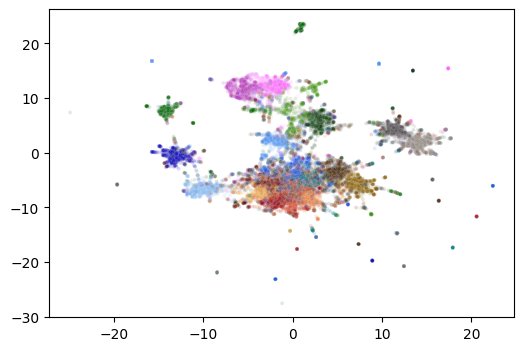

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=np.float64(0.573214475220206), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=np.float32(0.08566122), info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=np.float64(0.2918638791609183), info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=np.float64(0.23398811418868723), info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=np.float64(0.17828327850295378), info={'metric': 'euclidean', 'n_neighbors': 150})]

In [17]:
import drnb.embed.pipeline as pl

pl.standard_eval(
    "pacmap",
    dataset="ng20",
)

Maybe slightly better separation of clusters here?